# Hierarchical Clustering

In this notebook we explore the usage of the **Hierarchical Clustering** on the Customers' dataset.

In particular, we use the **Agglomerative** Hierarchical Clustering, that begins with every point in our dataset as a cluster. Then we find the two closest points and combine them into a cluster. Then, we find the next closest points, and those become a cluster. We repeat the process until we only have one big giant cluster.

We analyze this approach:
1. on the full dataset
2. on a manually selected subset of the dataset (Mean Days btw Purchases, Money Spent Entropy, Mean Products In Basket)
3. on a reduced dataset (PCA=2)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

img = 'plots/figure_{}.png'
dataFolder = '../../data/{}'

In [2]:
def visualize_in_2d(df):
    plt.figure()
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents, columns= ['principal component 1', 'principal component 2'])
    plt.title("Visualization of the Customers")
    plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=10)
    plt.show()

In [3]:
def perform_clustering(df, clusters, linkages, metrics):    
    results = []

    for k in clusters:
        print(f"\n\nNumber of Clusters: {k}")
        for l in linkages:
            print(f"\nLinkage: {l}")
            for metr in metrics:
                print(f"Metric: {metr}")
                if l == 'ward' and metr != 'euclidean':  # ward method exclusive with euclidean distance
                    continue
                res = AgglomerativeClustering(n_clusters=k, affinity=metr, linkage=l).fit(df)
                hist, bins = np.histogram(res.labels_, bins=range(0, len(set(res.labels_)) + 1))
                print('Cluster', dict(zip(bins, hist)))
                print('Silhouette Score', silhouette_score(df, res.labels_))

                results.append({
                    'res': res,
                    'k': k,
                    'silh': silhouette_score(df, res.labels_, metric = metr),
                    'link': l,
                    'metric': metr
                })
    return results

In [4]:
def plot_dendrogram(df, metr, link, eps):
    fig = plt.figure(figsize=(8,5))
    plt.title(f"{metr} {link}")
    data_dist = pdist(df, metric=metr)
    data_link = linkage(data_dist, method=link, metric=metr)
    dendrogram(data_link, color_threshold=eps, truncate_mode='lastp')
    plt.xlabel("Number of samples")
    plt.ylabel("Distance")
    #plt.savefig(img.format(f"dendr_{metr}_{link}"))
    plt.show()

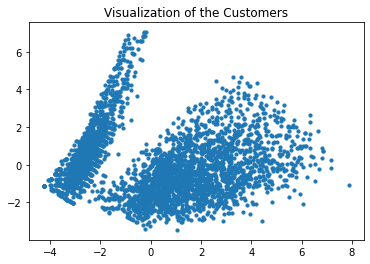

In [5]:
df = pd.read_csv(dataFolder.format('customer_behavior_wo_noise.csv'))
df = df.set_index('CustomerID')
idx = deepcopy(df.index)
cols = list(df.columns)
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df))
df.index = idx
df.columns = cols
df.head()
visualize_in_2d(df)

We decided to work with **numberOfClusters** $\in [2, 10]$. Let's compute the results of the Agglomerative Clustering with these parameters.

In [6]:
clusters = range(2, 11)
linkages = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

# 1. Considering the entire dataset

In [7]:
X = deepcopy(df)
results = perform_clustering(X, clusters, linkages, metrics)



Number of Clusters: 2

Linkage: ward
Metric: euclidean
Cluster {0: 2216, 1: 1508}
Silhouette Score 0.3047576134490312
Metric: manhattan

Linkage: complete
Metric: euclidean
Cluster {0: 3703, 1: 21}
Silhouette Score 0.3803866190195113
Metric: manhattan
Cluster {0: 2219, 1: 1505}
Silhouette Score 0.30439625501124784

Linkage: average
Metric: euclidean
Cluster {0: 3723, 1: 1}
Silhouette Score 0.6578573388678667
Metric: manhattan
Cluster {0: 3721, 1: 3}
Silhouette Score 0.5709149016505165

Linkage: single
Metric: euclidean
Cluster {0: 3723, 1: 1}
Silhouette Score 0.6578573388678667
Metric: manhattan
Cluster {0: 3723, 1: 1}
Silhouette Score 0.5205467635364909


Number of Clusters: 3

Linkage: ward
Metric: euclidean
Cluster {0: 1508, 1: 1015, 2: 1201}
Silhouette Score 0.22984512162840146
Metric: manhattan

Linkage: complete
Metric: euclidean
Cluster {0: 21, 1: 3254, 2: 449}
Silhouette Score 0.23386972157323666
Metric: manhattan
Cluster {0: 1435, 1: 1505, 2: 784}
Silhouette Score 0.19116901

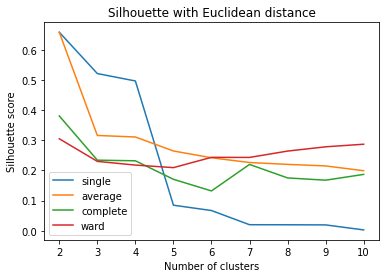

In [8]:
fig, ax = plt.subplots()
y1 = [a for a in results if a['link'] == 'single' and a['metric'] == 'euclidean']
y2 = [a for a in results if a['link'] == 'average' and a['metric'] == 'euclidean']
y3 = [a for a in results if a['link'] == 'complete' and a['metric'] == 'euclidean']
y4 = [a for a in results if a['link'] == 'ward' and a['metric'] == 'euclidean']

experiments = [y1, y2, y3, y4]

for exp in experiments:
  l = exp[0]['link']
  ax.plot(clusters, [s['silh'] for s in exp], label=l)

ax.set_title('Silhouette with Euclidean distance')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.legend(loc='lower left')
plt.savefig(img.format('silh_Euclidean_entire_dataset'))

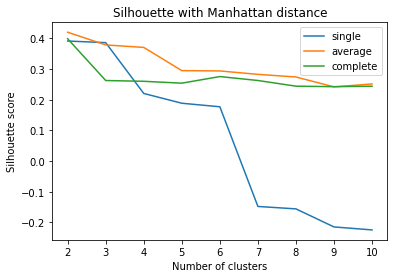

In [9]:
fig, ax = plt.subplots()
y1 = [a for a in results if a['link'] == 'single' and a['metric'] == 'manhattan']
y3 = [a for a in results if a['link'] == 'average' and a['metric'] == 'manhattan']
y4 = [a for a in results if a['link'] == 'complete' and a['metric'] == 'manhattan']

experiments = [y1, y3, y4]

for exp in experiments:
  l = exp[0]['link']
  ax.plot(clusters, [s['silh'] for s in exp], label=l)

ax.set_title('Silhouette with Manhattan distance')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.legend()
plt.savefig(img.format('silh_Manhattan_entire_dataset'))

Let's visualize the various dendrograms.

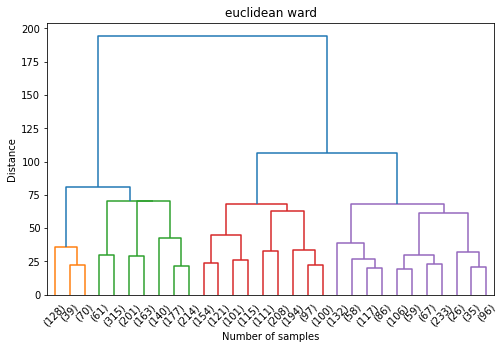

In [10]:
plot_dendrogram(X, 'euclidean', 'ward', 75)

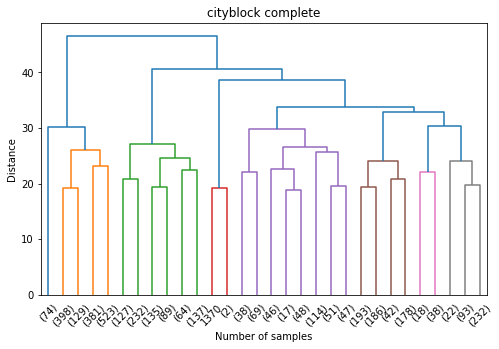

In [11]:
plot_dendrogram(X, 'cityblock', 'complete', 30)

# 2. Considering manually selected features
Let's consider only main features into account (according to "correlation_matrix_behavior").

In [12]:
X = deepcopy(df)
cols = ['Mean Days btw Purchases', 'Mean Products In Basket', 'Money Spent Entropy']
reduced_df = X[cols]
reduced_df.head()

,Mean Days btw Purchases,Mean Products In Basket,Money Spent Entropy
CustomerID,,,
12347,-0.625370,0.746764,1.559384
12349,1.192229,3.968380,0.720174
12350,1.192229,0.879159,-0.023469
12352,-0.908171,-0.599254,0.794202
12353,1.192229,-1.128835,-1.723677


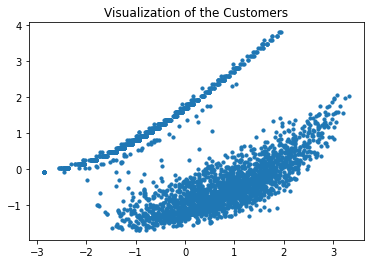

In [13]:
visualize_in_2d(reduced_df)

In [14]:
results = perform_clustering(reduced_df, clusters, linkages, metrics)



Number of Clusters: 2

Linkage: ward
Metric: euclidean
Cluster {0: 2671, 1: 1053}
Silhouette Score 0.4138720325062663
Metric: manhattan

Linkage: complete
Metric: euclidean
Cluster {0: 1826, 1: 1898}
Silhouette Score 0.3738989820680841
Metric: manhattan
Cluster {0: 2723, 1: 1001}
Silhouette Score 0.2515314897012808

Linkage: average
Metric: euclidean
Cluster {0: 1509, 1: 2215}
Silhouette Score 0.4817309402811884
Metric: manhattan
Cluster {0: 1514, 1: 2210}
Silhouette Score 0.48157147764079633

Linkage: single
Metric: euclidean
Cluster {0: 3723, 1: 1}
Silhouette Score -0.07809481564830324
Metric: manhattan
Cluster {0: 3723, 1: 1}
Silhouette Score -0.07809481564830324


Number of Clusters: 3

Linkage: ward
Metric: euclidean
Cluster {0: 934, 1: 1053, 2: 1737}
Silhouette Score 0.4315333502854505
Metric: manhattan

Linkage: complete
Metric: euclidean
Cluster {0: 1738, 1: 1898, 2: 88}
Silhouette Score 0.3537165349726819
Metric: manhattan
Cluster {0: 1692, 1: 1001, 2: 1031}
Silhouette Score

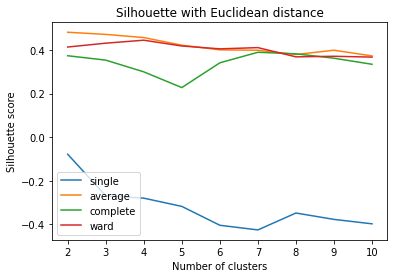

In [15]:
fig, ax = plt.subplots()
y1 = [a for a in results if a['link'] == 'single' and a['metric'] == 'euclidean']
y2 = [a for a in results if a['link'] == 'average' and a['metric'] == 'euclidean']
y3 = [a for a in results if a['link'] == 'complete' and a['metric'] == 'euclidean']
y4 = [a for a in results if a['link'] == 'ward' and a['metric'] == 'euclidean']

experiments = [y1, y2, y3, y4]

for exp in experiments:
    l = exp[0]['link']
    ax.plot(clusters, [s['silh'] for s in exp], label=l)

ax.set_title('Silhouette with Euclidean distance')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.legend(loc='lower left')
plt.savefig(img.format('silh_Euclidean_manually_selected_features'))

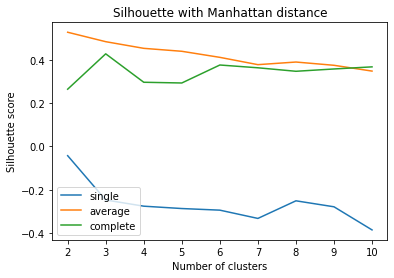

In [16]:
fig, ax = plt.subplots()
y1 = [a for a in results if a['link'] == 'single' and a['metric'] == 'manhattan']
y3 = [a for a in results if a['link'] == 'average' and a['metric'] == 'manhattan']
y4 = [a for a in results if a['link'] == 'complete' and a['metric'] == 'manhattan']

experiments = [y1, y3, y4]

for exp in experiments:
    l = exp[0]['link']
    ax.plot(clusters, [s['silh'] for s in exp], label=l)

ax.set_title('Silhouette with Manhattan distance')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.legend(loc='lower left')
plt.savefig(img.format('silh_Manhattan_manually_selected_features'))

Looking at the composition of the clusters and the realtive scores of the Silhouette we decided to stick with Average linkage with Euclidean distance and 4 clusters.

In [17]:
plot_res = next(x['res'] for x in results if x['k'] == 4 and x['metric'] == 'euclidean' and x['link'] == 'average')

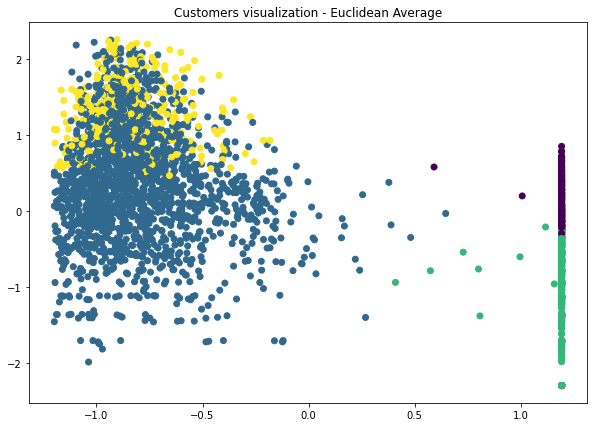

In [18]:
plt.figure(figsize=(10, 7))
plt.title('Customers visualization - Euclidean Average')
plt.scatter(reduced_df['Mean Days btw Purchases'], reduced_df['Money Spent Entropy'],  c=plot_res.labels_)
plt.savefig(img.format('customers_euclidean_average_selected_features_2d'))

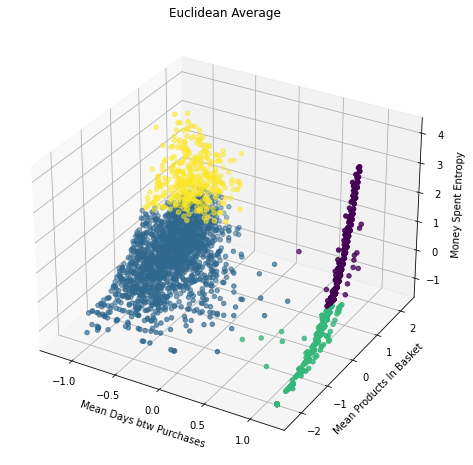

In [19]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.scatter(reduced_df['Mean Days btw Purchases'],
           reduced_df['Money Spent Entropy'],
           reduced_df['Mean Products In Basket'],           
           c=plot_res.labels_, marker='o')
ax.set_title('Euclidean Average')
ax.set_xlabel('Mean Days btw Purchases')
ax.set_ylabel('Mean Products In Basket')
ax.set_zlabel('Money Spent Entropy')
plt.savefig(img.format('customers_euclidean_average_selected_features_3d'))
plt.show()

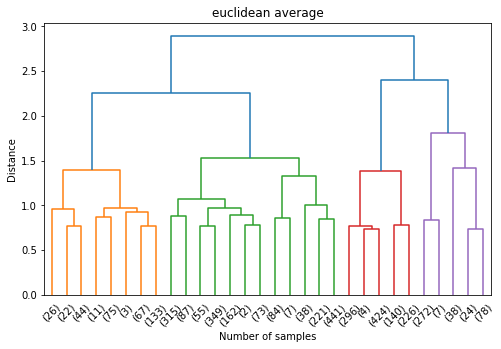

In [20]:
plot_dendrogram(reduced_df, 'euclidean', 'average', 2.0)

Let's plot also dendrograms generated with other type of linkage.

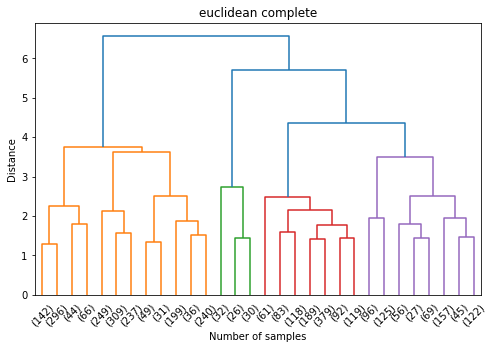

In [21]:
plot_dendrogram(reduced_df, 'euclidean', 'complete', 4.0)

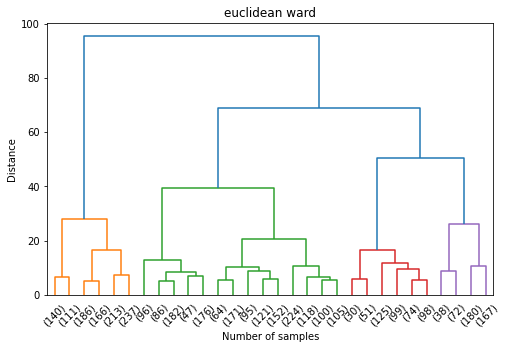

In [22]:
plot_dendrogram(reduced_df, 'euclidean', 'ward', 43)

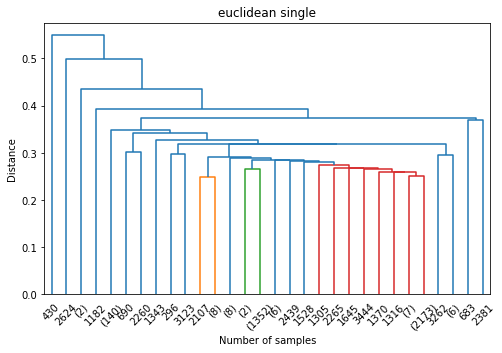

In [23]:
plot_dendrogram(reduced_df, 'euclidean', 'single', 0.28)

We can see that with Average we have the most balanced results, but also with Ward we have good results.

Let's now visualize the best configuration of clustering results considering **Manhattan** distance.

In [24]:
plot_res = next(x['res'] for x in results if x['k'] == 2 and x['metric'] == 'manhattan' and x['link'] == 'average')

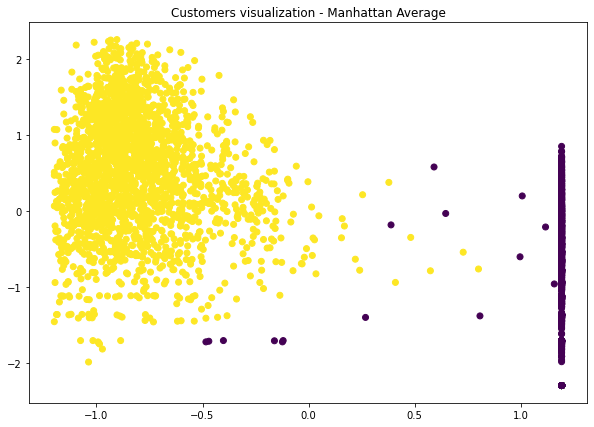

In [25]:
plt.figure(figsize=(10, 7))
plt.title('Customers visualization - Manhattan Average')
plt.scatter(reduced_df['Mean Days btw Purchases'], reduced_df['Money Spent Entropy'],  c=plot_res.labels_)
plt.savefig(img.format('customers_manhattan_average_selected_features_2d'))

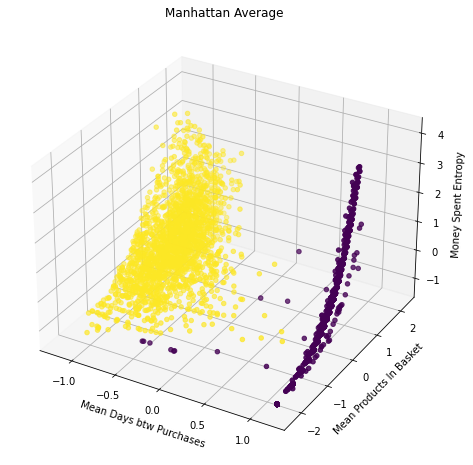

In [26]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.scatter(reduced_df['Mean Days btw Purchases'],
           reduced_df['Money Spent Entropy'],
           reduced_df['Mean Products In Basket'],           
           c=plot_res.labels_, marker='o')
ax.set_title('Manhattan Average')
ax.set_xlabel('Mean Days btw Purchases')
ax.set_ylabel('Mean Products In Basket')
ax.set_zlabel('Money Spent Entropy')
plt.savefig(img.format('customers_manhattan_average_selected_features_3d'))
plt.show()

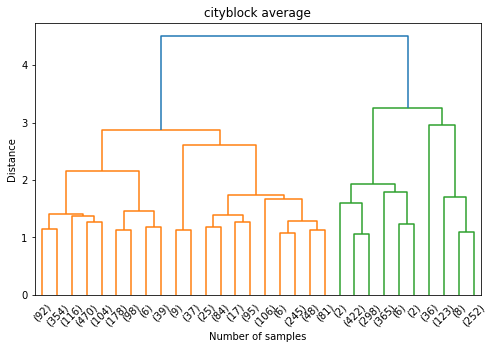

In [27]:
plot_dendrogram(reduced_df, 'cityblock', 'average', 3.3)

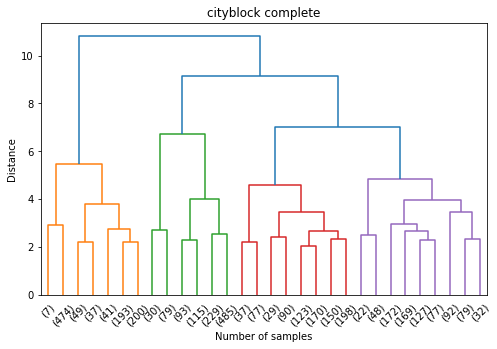

In [28]:
plot_dendrogram(reduced_df, 'cityblock', 'complete', 7)

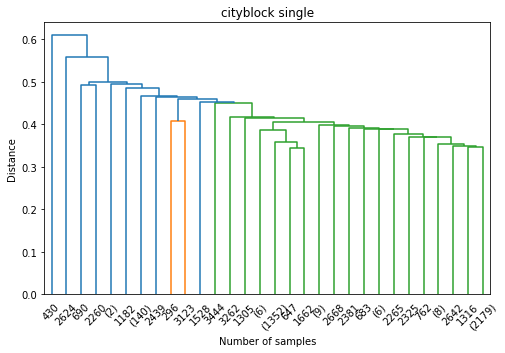

In [29]:
plot_dendrogram(reduced_df, 'cityblock', 'single', 0.45)

# 3. PCA
Let's now consider our original dataset in a reduced space, using **Principal Components Analysis**

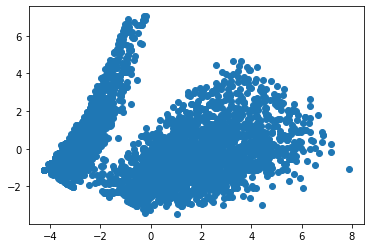

In [30]:
X = deepcopy(df)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
pca_df = pd.DataFrame(data = principalComponents, columns= ['principal component 1', 'principal component 2'])

plt.scatter(pca_df['principal component 1'], pca_df['principal component 2'])

In [31]:
results = perform_clustering(pca_df, clusters, linkages, metrics)



Number of Clusters: 2

Linkage: ward
Metric: euclidean
Cluster {0: 2219, 1: 1505}
Silhouette Score 0.4908618161914003
Metric: manhattan

Linkage: complete
Metric: euclidean
Cluster {0: 2762, 1: 962}
Silhouette Score 0.387078307994934
Metric: manhattan
Cluster {0: 2880, 1: 844}
Silhouette Score 0.37824219890514815

Linkage: average
Metric: euclidean
Cluster {0: 3723, 1: 1}
Silhouette Score 0.46905563851464793
Metric: manhattan
Cluster {0: 3723, 1: 1}
Silhouette Score 0.46905563851464793

Linkage: single
Metric: euclidean
Cluster {0: 3723, 1: 1}
Silhouette Score 0.46905563851464793
Metric: manhattan
Cluster {0: 3723, 1: 1}
Silhouette Score 0.46905563851464793


Number of Clusters: 3

Linkage: ward
Metric: euclidean
Cluster {0: 1505, 1: 1062, 2: 1157}
Silhouette Score 0.4159994894091494
Metric: manhattan

Linkage: complete
Metric: euclidean
Cluster {0: 962, 1: 2624, 2: 138}
Silhouette Score 0.3457084665617524
Metric: manhattan
Cluster {0: 2709, 1: 844, 2: 171}
Silhouette Score 0.3336938

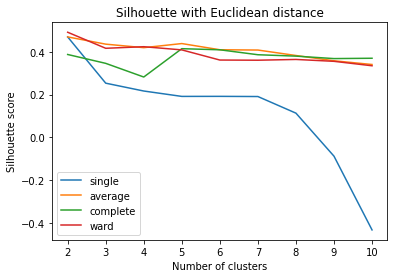

In [32]:
fig, ax = plt.subplots()
y1 = [a for a in results if a['link'] == 'single' and a['metric'] == 'euclidean']
y2 = [a for a in results if a['link'] == 'average' and a['metric'] == 'euclidean']
y3 = [a for a in results if a['link'] == 'complete' and a['metric'] == 'euclidean']
y4 = [a for a in results if a['link'] == 'ward' and a['metric'] == 'euclidean']

experiments = [y1, y2, y3, y4]

for exp in experiments:
    l = exp[0]['link']
    ax.plot(clusters, [s['silh'] for s in exp], label=l)

ax.set_title('Silhouette with Euclidean distance')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.legend(loc='lower left')
plt.savefig(img.format('silh_Euclidean_pca'))

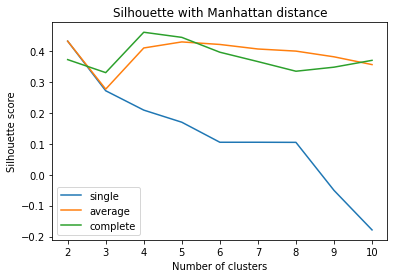

In [33]:
fig, ax = plt.subplots()
y1 = [a for a in results if a['link'] == 'single' and a['metric'] == 'manhattan']
y3 = [a for a in results if a['link'] == 'average' and a['metric'] == 'manhattan']
y4 = [a for a in results if a['link'] == 'complete' and a['metric'] == 'manhattan']

experiments = [y1, y3, y4]

for exp in experiments:
    l = exp[0]['link']
    ax.plot(clusters, [s['silh'] for s in exp], label=l)

ax.set_title('Silhouette with Manhattan distance')
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Silhouette score")
ax.legend(loc='lower left')
plt.savefig(img.format('silh_Manhattan_pca'))

Looking at the composition of the clusters and the realtive scores of the Silhouette we decided to stick to Ward linkage with Euclidean distance and 4 clusters.

In [34]:
plot_res = next(x['res'] for x in results if x['k'] == 4 and x['metric'] == 'euclidean' and x['link'] == 'ward')

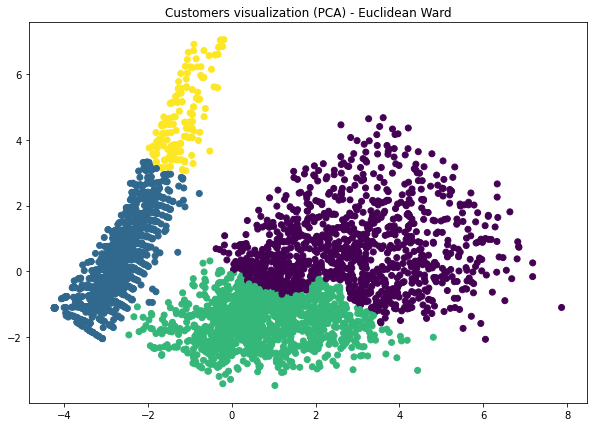

In [35]:
plt.figure(figsize=(10, 7))
plt.title('Customers visualization (PCA) - Euclidean Ward')
plt.scatter(pca_df['principal component 1'], pca_df['principal component 2'],  c=plot_res.labels_)
plt.savefig(img.format('customers_Euclidean_Ward_pca'))

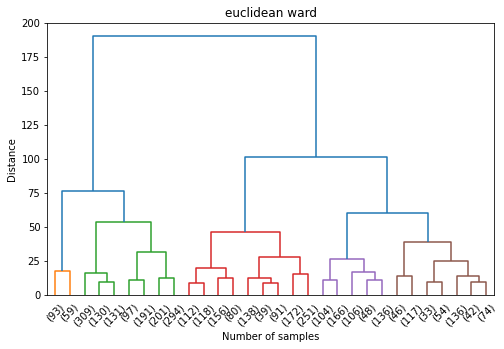

In [36]:
plot_dendrogram(pca_df, 'euclidean', 'ward', 60)

Let's plot also dendrograms generated with other type of linkage.

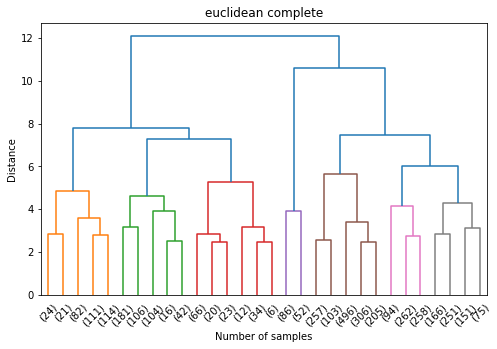

In [37]:
plot_dendrogram(pca_df, 'euclidean', 'complete', 6)

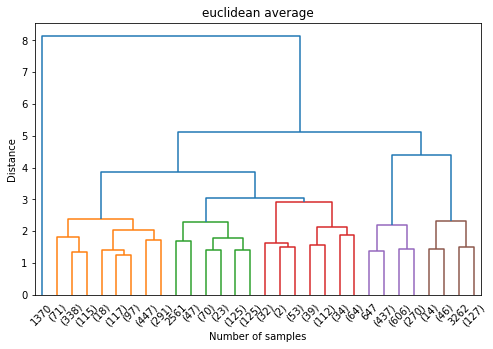

In [38]:
plot_dendrogram(pca_df, 'euclidean', 'average', 3)

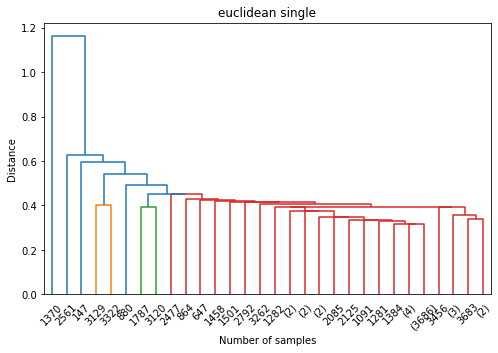

In [39]:
plot_dendrogram(pca_df, 'euclidean', 'single', 0.45)

We can see that with Ward we have the most balanced results, but also with Complete we have comparable results.

Let's now visualize the best configuration of clustering results considering **Manhattan** distance.

In [40]:
plot_res = next(x['res'] for x in results if x['k'] == 5 and x['metric'] == 'manhattan' and x['link'] == 'average')

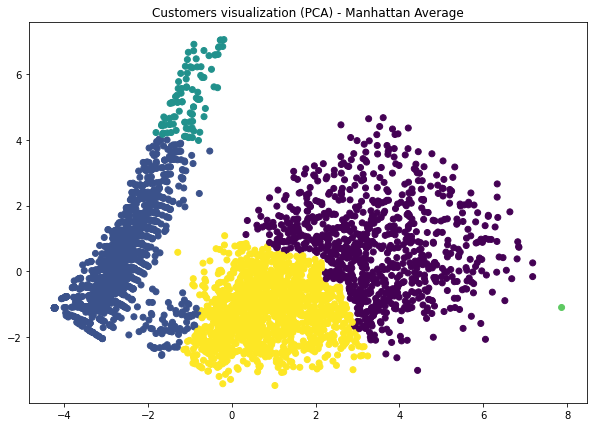

In [41]:
plt.figure(figsize=(10, 7))
plt.title('Customers visualization (PCA) - Manhattan Average')
plt.scatter(pca_df['principal component 1'], pca_df['principal component 2'],  c=plot_res.labels_)
plt.savefig(img.format('customers_manhattan_average_pca'))

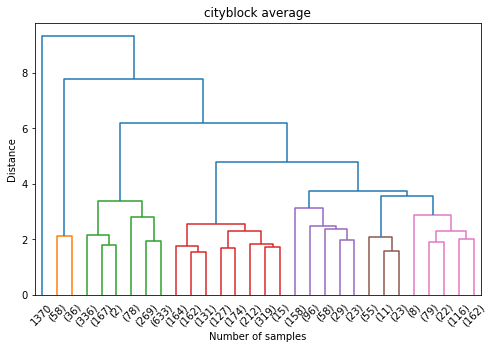

In [42]:
plot_dendrogram(pca_df, 'cityblock', 'average', 3.5)

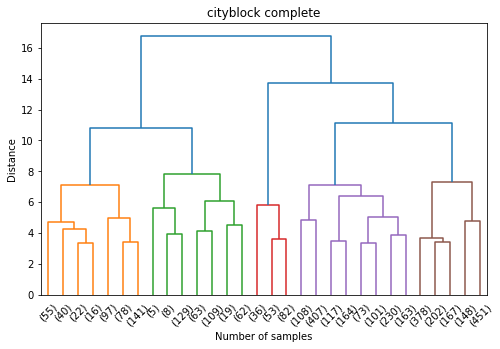

In [43]:
plot_dendrogram(pca_df, 'cityblock', 'complete', 9)

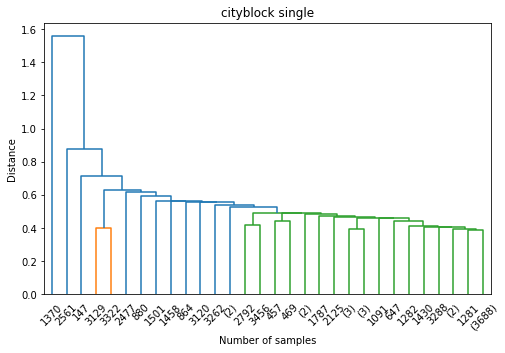

In [44]:
plot_dendrogram(pca_df, 'cityblock', 'single', 0.52)

In general, the advantage of agglomerative hierarchical clustering is that it tends to produce more accurate results. The downside is that hierarchical clustering is more difficult to implement and more time/resource consuming than k-means.